In [1]:
import autograd 

import autograd.numpy as np
import autograd.scipy as sp
from numpy.polynomial.hermite import hermgauss

import sys
sys.path.insert(0, '../')

import structure_model_lib
import data_utils
import paragami

In [2]:
from BNP_modeling import cluster_quantities_lib, modeling_lib
import BNP_modeling.optimization_lib as opt_lib

from itertools import permutations

import matplotlib.pyplot as plt
%matplotlib inline  

import vittles

from copy import deepcopy

In [3]:
np.random.seed(53453)

# Draw data

In [4]:
n_obs = 50
n_loci = 40
n_pop = 4

# population allele frequencies
true_pop_allele_freq = np.random.random((n_loci, n_pop))

# individual admixtures
true_ind_admix_propn = np.random.dirichlet(np.ones(n_pop) / n_pop, size = (n_obs))

In [5]:
clustering_indx = data_utils.cluster_admix_get_indx(true_ind_admix_propn)
true_ind_admix_propn = true_ind_admix_propn[clustering_indx, :]

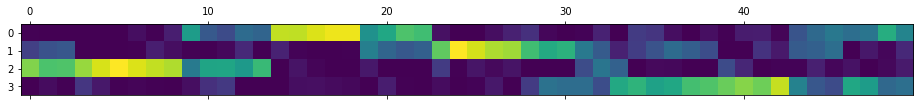

In [6]:
plt.matshow(true_ind_admix_propn.T)

In [7]:
g_obs = data_utils.draw_data(true_pop_allele_freq, true_ind_admix_propn)

# Get prior

In [8]:
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()

print(prior_params_paragami)

OrderedDict:
	[dp_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_beta] = NumericArrayPattern (1,) (lb=0.0, ub=inf)


# Get VB params 

In [9]:
k_approx = 12

In [10]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(8)

In [11]:
vb_params_dict, vb_params_paragami = \
    structure_model_lib.get_vb_params_paragami_object(n_obs, n_loci, k_approx)
    
print(vb_params_paragami)

OrderedDict:
	[pop_freq_beta_params] = NumericArrayPattern (40, 12, 2) (lb=0.0, ub=inf)
	[ind_mix_stick_propn_mean] = NumericArrayPattern (50, 11) (lb=-inf, ub=inf)
	[ind_mix_stick_propn_info] = NumericArrayPattern (50, 11) (lb=0.0001, ub=inf)


In [12]:
stick_propn_mean = vb_params_dict['ind_mix_stick_propn_mean']
stick_propn_info = vb_params_dict['ind_mix_stick_propn_info']
pop_freq_beta_params = vb_params_dict['pop_freq_beta_params']

In [13]:
n_samples = 10000

In [14]:
unif_samples_shape = (n_samples, ) + stick_propn_mean.shape
unv_norm_samples = np.random.normal(0, 1, size = unif_samples_shape)

In [15]:
stick_propn_samples = sp.special.expit(unv_norm_samples * \
                            1 / np.sqrt(stick_propn_info) + \
                                        stick_propn_mean)

In [16]:
stick_propn_info.shape

(50, 11)

In [17]:
stick_propn_samples.shape

(10000, 50, 11)

In [18]:
weight_samples = cluster_quantities_lib.get_mixture_weights_from_stick_break_propns(stick_propn_samples)

In [19]:
weight_samples.shape

(10000, 50, 12)

In [20]:
cluster_quantities_lib.get_e_number_clusters_from_logit_sticks(stick_propn_mean, stick_propn_info,
                                            n_samples = 100, 
                                            n_obs = 100)

array([4.97145007, 4.97236484, 4.84848045, 5.04234432, 5.31758263,
       5.30142244, 5.28254983, 4.89934724, 5.69527242, 5.58105825,
       5.36914885, 5.16338456, 5.15805919, 5.0489563 , 4.72380272,
       5.08580287, 5.29152956, 5.05269463, 4.73425609, 4.83377779,
       5.03812815, 4.55965105, 5.24097181, 4.84151504, 5.50300301,
       4.88728371, 4.8430293 , 5.43552422, 4.99510762, 4.68293017,
       4.96861348, 5.06077275, 4.90856697, 5.11257667, 4.93984956,
       5.20477557, 5.61110364, 4.72293234, 5.42826237, 4.64253788,
       4.96912208, 4.79851598, 5.53002281, 5.47038606, 5.04977692,
       5.08348738, 5.3536015 , 4.70004343, 4.45382774, 5.18105409])

In [21]:
def get_optimal_e_z_from_dicts(vb_params_dict, prior_params_dict): 
    # get prior parameters
    dp_prior_alpha = prior_params_dict['dp_prior_alpha']
    allele_prior_alpha = prior_params_dict['allele_prior_alpha']
    allele_prior_beta = prior_params_dict['allele_prior_beta']

    # get vb parameters
    ind_mix_stick_propn_mean = vb_params_dict['ind_mix_stick_propn_mean']
    ind_mix_stick_propn_info = vb_params_dict['ind_mix_stick_propn_info']
    pop_freq_beta_params = vb_params_dict['pop_freq_beta_params']

    e_log_p, e_log_1mp = modeling_lib.get_e_log_beta(pop_freq_beta_params)

    loglik_cond_z = \
                structure_model_lib.get_loglik_cond_z(g_obs, e_log_p, e_log_1mp,
                                ind_mix_stick_propn_mean, ind_mix_stick_propn_info,
                                gh_loc, gh_weights)

    return structure_model_lib.get_z_opt_from_loglik_cond_z(loglik_cond_z)

In [22]:
_e_z = get_optimal_e_z_from_dicts(vb_params_dict, prior_params_dict)
e_z = _e_z.swapaxes(2, 3)

In [23]:
cluster_quantities_lib.get_e_num_large_clusters_from_ez(e_z,
                                    threshold = 0,
                                    n_samples = 1222)

AssertionError: 